In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

d:\Anaconda\package\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\package\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
d:\Anaconda\package\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
d:\Anaconda\package\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
actions = np.array(['start', 'end', 'turn_left','turn_right', 'go_forward', 'go_backward'])
label_map = {label:num for num, label in enumerate(actions)}

In [3]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 
# Thirty videos worth of data
no_sequences = 360
# Videos are going to be 30 frames in length
sequence_length = 5
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [5]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [6]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(5,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [7]:
model.fit(X_train, y_train, epochs=2000, validation_data=(X_test, y_test), callbacks=[tb_callback], shuffle=True)

Epoch 1/2000
65/65 [==============================] - 7s 48ms/step - loss: 2.6387 - categorical_accuracy: 0.3054 - val_loss: 1.9992 - val_categorical_accuracy: 0.4259
Epoch 2/2000
65/65 [==============================] - 1s 9ms/step - loss: 1.8152 - categorical_accuracy: 0.4494 - val_loss: 1.6076 - val_categorical_accuracy: 0.4907
Epoch 3/2000
65/65 [==============================] - 1s 9ms/step - loss: 1.3852 - categorical_accuracy: 0.5946 - val_loss: 1.2828 - val_categorical_accuracy: 0.4722
Epoch 4/2000
65/65 [==============================] - 1s 9ms/step - loss: 1.1827 - categorical_accuracy: 0.6450 - val_loss: 1.4014 - val_categorical_accuracy: 0.4167
Epoch 5/2000
65/65 [==============================] - 1s 11ms/step - loss: 1.0606 - categorical_accuracy: 0.6852 - val_loss: 0.8632 - val_categorical_accuracy: 0.7870
Epoch 6/2000
65/65 [==============================] - 1s 11ms/step - loss: 0.8296 - categorical_accuracy: 0.8133 - val_loss: 0.6754 - val_categorical_accuracy: 0.8981
E

KeyboardInterrupt: 

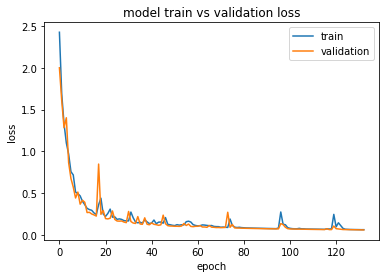

In [8]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

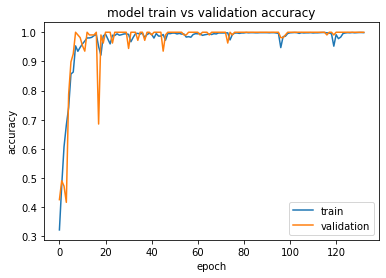

In [9]:
plt.plot(model.history.history['categorical_accuracy'])
plt.plot(model.history.history['val_categorical_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             48896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 203,558
Trainable params: 203,558
Non-trainable params: 0
__________________________________________________

In [11]:
model.save('action.h5')